In [3]:
import matplotlib.pyplot as plt
import hopsy
import os
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
from scipy.optimize import curve_fit
from PolyRound.api import PolyRoundApi

In [1]:
class Boltzman_Modell:
    def __init__(self, beta, index):
        self.beta = beta
        self.index = index
        
    def compute_negative_log_likelihood(self, x):
        return - self.beta * x[self.index]

In [4]:
model_path = os.path.join("C:/Users/carol/OneDrive/Desktop/Juelich", "e_coli_core.xml")

In [5]:
raw_polytope = PolyRoundApi.sbml_to_polytope(model_path)
biomass_index = raw_polytope.A.columns.tolist().index('BIOMASS_Ecoli_core_w_GAM')
glucose_uptake_index = raw_polytope.A.columns.tolist().index('EX_glc__D_e')
polytope = PolyRoundApi.simplify_transform_and_round(raw_polytope)



In [6]:
uniform = hopsy.Problem(A=polytope.A, b=polytope.b, transformation=polytope.transformation, shift=polytope.shift)
starting_point = hopsy.compute_chebyshev_center(uniform)

In [19]:
# Für die Boltzmann-Verteilung
a = np.array(0)
model_Boltzmann = Boltzman_Modell(a, biomass_index)
uniform_2 = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_Boltzmann, transformation=polytope.transformation, shift=polytope.shift)
starting_point_2 = hopsy.compute_chebyshev_center(uniform_2)

In [16]:
# Für die Boltzmann-Verteilung
a = np.array(10)
model_Boltzmann = Boltzman_Modell(a, biomass_index)
boltzmann_1 = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_Boltzmann, transformation=polytope.transformation, shift=polytope.shift)
starting_point_boltzmann = hopsy.compute_chebyshev_center(boltzmann_1)

In [17]:
# Für die Boltzmann-Verteilung
a = np.array(-10)
model_Boltzmann = Boltzman_Modell(a, biomass_index)
boltzmann_2 = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_Boltzmann, transformation=polytope.transformation, shift=polytope.shift)
starting_point_boltzmann_2 = hopsy.compute_chebyshev_center(boltzmann_2)

In [32]:
# Für die Boltzmann-Verteilung
a = np.array(-100)
model_Boltzmann = Boltzman_Modell(a, biomass_index)
boltzmann_3 = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_Boltzmann, transformation=polytope.transformation, shift=polytope.shift)
starting_point_boltzmann_3 = hopsy.compute_chebyshev_center(boltzmann_3)

In [33]:
problems = {
    'uniform': [uniform, starting_point],
     'beta=0': [uniform_2, starting_point_2],  
     'beta=10': [boltzmann_1, starting_point_boltzmann], 
     'beta=-10': [boltzmann_2, starting_point_boltzmann_2], 
     'beta = -100': [boltzmann_3, starting_point_boltzmann_3]
    }

In [34]:
rhat = {}
ess = {}
samples = {}
acceptance_rate = {}
n_chains = 4 
n_samples = 10000
thinning = 10

for p, liste in problems.items():
    v = liste[0]
    s = liste[1]
    print(p)
    proposal = hopsy.UniformCoordinateHitAndRunProposal(v, starting_point=s)
    mcs = [hopsy.MarkovChain(problem=v, proposal=proposal) for i in range(n_chains)]
    rngs = [hopsy.RandomNumberGenerator(i) for i in range(n_chains)]
    acceptance_rate[p], samples[p] = hopsy.sample(mcs, rngs, n_samples=n_samples, thinning=thinning, n_procs=1)
    ess[p] = hopsy.ess(samples[p])
    print('\tess', np.min(ess[p]))
    rhat[p] = hopsy.rhat(samples[p])
    print('\trhat', np.max(rhat[p]))

uniform
	ess 730.2609014651691
	rhat 1.0066610470050092
beta=0
	ess 730.2609014651691
	rhat 1.0066610470050092
beta=10
	ess 513.4994025716682
	rhat 1.0146139396556348
beta=-10
	ess 721.0720572874002
	rhat 1.008430502564084
beta = -100
	ess 319.5445972834105
	rhat 1.0131128546046237


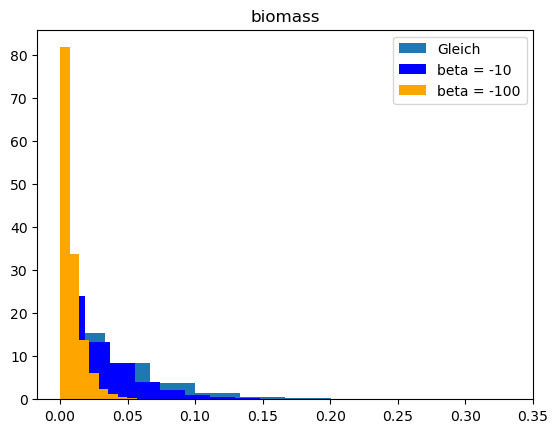

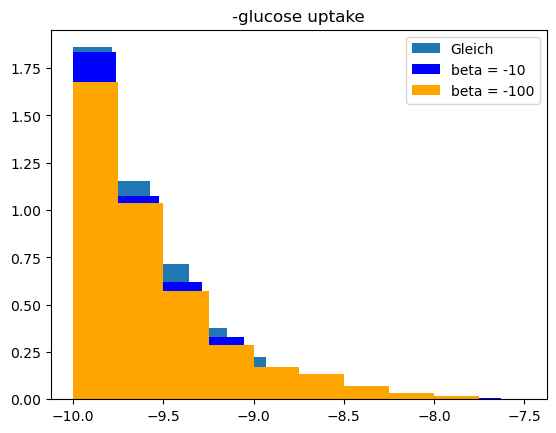

In [35]:
plt.title('biomass')
plt.hist(samples['uniform'][0, :, biomass_index], density = True, label = "Gleich")
# TODO
#plt.hist(samples['beta=0'][0, :, biomass_index], density = True, color = "red",label = "beta = 0" )
#plt.hist(samples['beta=10'][0, :, biomass_index], density = True, color = "green", label = "beta = 10")
plt.hist(samples['beta=-10'][0, :, biomass_index], density = True, color = "blue", label = "beta = -10")
plt.hist(samples['beta = -100'][0, :, biomass_index], density = True, color = "orange", label = "beta = -100")
plt.legend(loc='upper right')
plt.show()
plt.title('-glucose uptake')
plt.hist(samples['uniform'][0, :, glucose_uptake_index], density = True, label = "Gleich")
#plt.hist(samples['beta=0'][0, :, glucose_uptake_index], density = True, color = "red",label = "beta = 0")
#plt.hist(samples['beta=10'][0, :, glucose_uptake_index], density = True, color = "green", label = "beta = 10")
plt.hist(samples['beta=-10'][0, :, glucose_uptake_index], density = True, color = "blue", label = "beta = -10")
plt.hist(samples['beta = -100'][0, :, glucose_uptake_index], density = True, color = "orange", label = "beta = -100")
plt.legend(loc='upper right')
plt.show()

In [36]:
help(hopsy.MarkovChain)

Help on function MarkovChain in module hopsy.misc:

MarkovChain(problem: hopsy.core.Problem, proposal: Union[hopsy.core.Proposal, Type[hopsy.core.Proposal]] = <class 'hopsy.core.GaussianHitAndRunProposal'>, starting_point: Union[numpy.__array_like._SupportsArray[numpy.dtype], numpy.__nested_sequence._NestedSequence[numpy.__array_like._SupportsArray[numpy.dtype]], bool, int, float, complex, str, bytes, numpy.__nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]] = None, parallelTemperingSyncRng: hopsy.core.RandomNumberGenerator = None, exchangeAttemptProbability: float = 0.1)
    MarkovChain(problem, proposal=hopsy.GaussianHitAndRun, starting_point=None)
    
    Given a hopsy.Problem a MarkovChain object can be constructed. The Markov chain keeps track of the internal state and the selected proposal mechanism, see proposal argument.
    Several Markov chain objects can be sampled in parallel by passing them as a list to hopsy.sample.

